In [99]:
# Import the required libraries

import pandas as pd
import chardet
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTENC
from collections import Counter
import xgboost as xgb
import matplotlib.pyplot as plt


In [79]:
def detect_encoding(file_path):
    """Detect the most probable character encoding for a file"""
    with open(file_path, 'rb') as f:
        raw_data = f.read()
        result = chardet.detect(raw_data)
        return result['encoding']
    
detect_encoding('customer_booking.csv')

'ISO-8859-1'

In [80]:
def load_csv_file(csv_path):
    """Load the CSV file from the disk and prints the shape."""

    data = pd.read_csv(csv_path, encoding='ISO-8859-1')

    data_shape = data.shape
    print(f"The data loaded: It contains {data_shape[0]} rows and {data_shape[1]} columns")
    print(f"The column names are: {data.columns}")

    return data


df = load_csv_file("customer_booking.csv")

The data loaded: It contains 50000 rows and 14 columns
The column names are: Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')


In [81]:
def data_cleaning(data):
    """Clean the data by, convert object to category, map week days."""

    # Map the week day
    week_day_map = {
        "Mon": 1,
        "Tue": 2,
        "Wed": 3,
        "Thu": 4,
        "Fri": 5,
        "Sat": 6,
        "Sun": 7
    }
    data["flight_day"] = data['flight_day'].map(week_day_map)

    # Convert all the object columns to category
    object_columns = data.select_dtypes(include='object').columns.to_list()
    data[object_columns] = data[object_columns].astype('category')

    return data 
data = data_cleaning(df)

In [82]:
def split_data(data):
    """Split the data into train and test"""
    train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['booking_complete'])

    return train_set, test_set 

train_set, test_set = split_data(data)

In [83]:
def over_sample_imbalance_class(train_set):
    """Over-sample the imbalance class using Synthetic Minority Over-sampling Techinque for Nominal and Continuous (SMOTENC)"""

    sm = SMOTENC(categorical_features='auto', random_state=42)

    x_train = train_set.drop(columns=['booking_complete'], axis=1)
    y_train = train_set['booking_complete']
    print(f"The class counts of y_train before resampling: {Counter(y_train)}")

    x_train_resampled, y_train_resampled = sm.fit_resample(x_train, y_train)
    print(f"The class counts of y_train_resample: { Counter(y_train_resampled)}")

    return x_train_resampled, y_train_resampled
    
x_train_resampled, y_train_resampled = over_sample_imbalance_class(train_set)

The class counts of y_train before resampling: Counter({0: 34018, 1: 5982})
The class counts of y_train_resample: Counter({1: 34018, 0: 34018})


In [86]:
# HistGradientBoostingClassifier natively supports categorical columns. The category columns will be inferred from the data type.
# The first used did not categorical columns with more than 255 unique categories.

def xgb_model():
    """Instantiate the model"""
    model = xgb.XGBClassifier(
        tree_method="hist",
        enable_categorical=True,
        eval_metric='logloss',
        random_state=42,
    )
    
    return model

xgboost_model = xgb_model()

In [87]:
def train_model(model, x_train, y_train, cv=5):
    """Train the model"""
    params = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
        'max_depth': [3, 4, 5, 6, 7]
    }
    grid = GridSearchCV(estimator=model,
                        param_grid=params,
                        cv=cv,
                        scoring='roc_auc',
                        n_jobs=-1,
                        verbose=1
                        )
    grid.fit(x_train, y_train)

    print(f"Best parameters: {grid.best_params_}\n")
    print(f"Best ROC AUC: {grid.best_score_: .2f}")

    return grid

grid = train_model(xgboost_model, x_train_resampled, y_train_resampled)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


/Users/user/Code/Forage/British-Airways-Reviews/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 500}

Best ROC AUC:  0.95


In [88]:
best_model = grid.best_estimator_

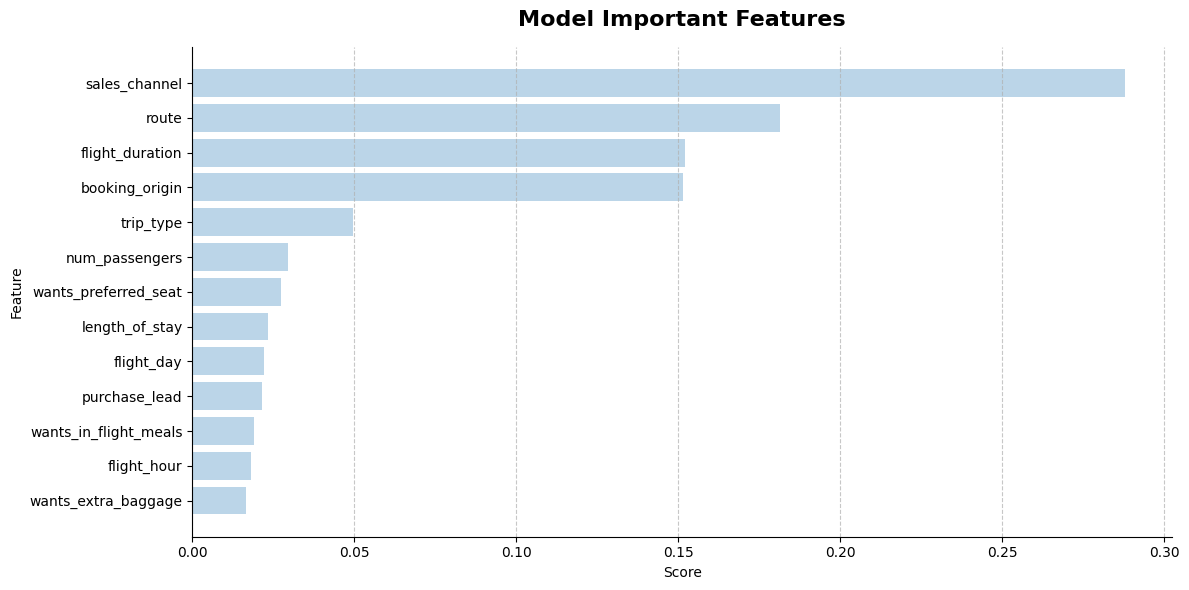

In [116]:
def setup_plot_style(ax):
    """Apply plot styling"""
    ax.set_ylabel('Feature')
    ax.set_xlabel('Score')
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('Model Important Features', pad=15, fontsize=16, fontweight='bold')

# Get feature importances
fig, ax = plt.subplots(figsize=(12, 6))
important_features = pd.Series(best_model.feature_importances_, index=x_train_resampled.columns.to_list()).sort_values(ascending=True)
bars = ax.barh(important_features.index, important_features, alpha=0.3, height=0.8)
setup_plot_style(ax)
plt.tight_layout()
plt.show();

In [117]:
# Evaluate the model on the train_set
train_accuracy = best_model.score(x_train_resampled, y_train_resampled)
print(f"Train accuracy: {train_accuracy: .2f}")


Train accuracy:  0.99


In [101]:
# Evaluate the model
x_test = test_set.drop('booking_complete', axis=1)
y_test = test_set['booking_complete']
test_accuracy = best_model.score(x_test, y_test)
print(f"Test set accuracy: { test_accuracy: .2f}")

Test set accuracy:  0.82


In [47]:
df.booking_complete.value_counts(normalize=True) # 85 percent of the data consists of one class (0 class). This means that there is 85 percent chance of randomly selecting the 0-class from the dataset. To fix this issue, the training dataset is balanced using Synthetic Minority Over-Sampling Technique (SMOTE).

booking_complete
0    0.85044
1    0.14956
Name: proportion, dtype: float64